In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy import stats
import cupy as cp
import cupyx.scipy.sparse as sp
from cupyx.scipy.sparse.linalg import gmres


In [2]:
root = "C:/users/yabec/desktop/dependencynet/"
nodes = pd.read_csv(root+'githubcode/testdata_nodes.csv')
network = pd.read_csv(root+'githubcode/testdata.xz')

# Leontief computation

In [3]:
def get_Amatrix(network, beta, thistype='cupy'):
    allpois1 = network['poi_a'].unique()
    allpois2 = network['poi_b'].unique()
    allpois = sorted(np.unique(np.concatenate((allpois1, allpois2), axis=None)))
    pois_newid = pd.DataFrame({'oldid':allpois, 'newid':np.arange(len(allpois))})

    deps = (network[['poi_a','poi_b','dep']]
            .merge(pois_newid, left_on='poi_a', right_on='oldid', how='left').rename(columns={'newid':'poi_a_new'})
            .merge(pois_newid, left_on='poi_b', right_on='oldid', how='left').rename(columns={'newid':'poi_b_new'}))
    
    # if some nodes do not exist on one side, add a weight=0 line for data configuration
    Xset = list(set(pois_newid['newid'].values))
    Yset = list(set(deps['poi_a_new'].values))
    notincl = [x for x in Xset if x not in Yset]
    notincl_pair = [random.randint(0, np.max(pois_newid['newid'].values)) for _ in range(len(notincl))]
    notincl_dep = np.ones(len(notincl))*0.00001
    addi = pd.DataFrame({'poi_a_new':notincl, 'poi_b_new':notincl_pair, 'dep':notincl_dep})
    deps = deps.append(addi, ignore_index=True)
    
    numrows = deps['poi_a_new'].max()+1
    numcols = deps['poi_b_new'].max()+1
    dim = np.max((numrows,numcols))

    ### cupy
    if thistype=='cupy':
        matrix = sp.coo_matrix((cp.asarray(deps.dep),(cp.asarray(deps.poi_a_new),cp.asarray(deps.poi_b_new)))).tocsr()
        # betas  = sp.coo_matrix((cp.asarray(deps.coeff),(cp.asarray(deps.poi_a_new),cp.asarray(deps.poi_b_new)))).tocsr()
        ident = sp.identity(dim).tocsr()
        
    elif thistype=='scipy':
        matrix = sparse.coo_matrix((np.asarray(deps.dep),(np.asarray(deps.poi_a_new),np.asarray(deps.poi_b_new)))).tocsr()
        # betas  = sp.coo_matrix((cp.asarray(deps.coeff),(cp.asarray(deps.poi_a_new),cp.asarray(deps.poi_b_new)))).tocsr()
        ident = sparse.identity(dim).tocsr()
        
    print(ident.shape,matrix.shape)
        
    A = ident - beta*matrix
    return A, pois_newid

In [14]:
def get_Bvector(pois_newid, dfpoinew):
 
    ### choose nodes to add shock to 
    def applyshock(row):
        if 'College' in row['Taxonomy']:
            return 1
        else:
            return 0
        
    pois_newid_cat = (pois_newid.merge(nodes[['id','Taxonomy','cat']].drop_duplicates(subset='id'), 
                                       left_on='oldid', right_on='id', how='left').drop(columns='id'))
    pois_newid_cat['fe'] = pois_newid_cat.apply(lambda row: applyshock(row), axis=1)
    b = cp.asarray(pois_newid_cat['fe'].values)
    return b,pois_newid_cat

In [8]:
beta = .25
A_real, pois_newid_real = get_Amatrix(network, beta)

(8712, 8712) (8712, 8712)


In [15]:
b_real, pois_newid_cat_real = get_Bvector(pois_newid_real, nodes)

In [22]:
x_real,info_real = gmres(A_real, b_real)
pois_newid_cat_real['res'] = x_real.get()

C:\Users\yabec\anaconda3\envs\py38\lib\site-packages\cupyx\scipy\sparse\linalg\_iterative.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ret = numpy.linalg.lstsq(cupy.asnumpy(H), e)


In [27]:
# plt.scatter(pois_newid_cat_real['fe'],pois_newid_cat_real['res'])
pois_newid_cat_real = pois_newid_cat_real.merge(nodes[['id','poilon','poilat']], left_on='oldid', right_on='id', how='left')

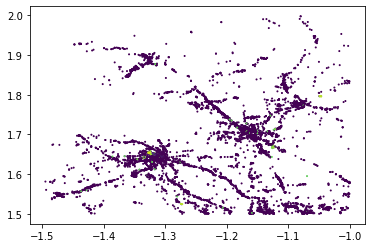

In [30]:
plt.scatter(pois_newid_cat_real['poilon'],pois_newid_cat_real['poilat'],c=pois_newid_cat_real['res'], s=1)